In [76]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

### Direct Links

1. [To get top 10 by genre](#best_genre)
2. [To get top 10 similar users](#top_ten)

In [77]:
# Reading the ratings data
ratings = pd.read_csv('Dataset/ratings.csv')

In [78]:
len(ratings)

1048575

In [79]:
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]

In [80]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [81]:
# In this case there are no such cases where the user has rated the same movie twice.
len(ratings_df)

1048575

In [82]:
# Inspecting the data
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [83]:
ratings_df.head()

rating
userId movieId        
1      2           3.5
       29          3.5
       32          3.5
       47          3.5
       50          3.5

In [84]:
# Counting no of unique users
len(ratings['userId'].unique())

7120

In [85]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [86]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,13232,13232,1.3
1.0,35144,35144,3.4
1.5,14029,14029,1.3
2.0,74706,74706,7.1
2.5,44791,44791,4.3
3.0,226202,226202,21.6
3.5,112926,112926,10.8
4.0,295135,295135,28.1
4.5,79848,79848,7.6


<AxesSubplot:xlabel='rating'>

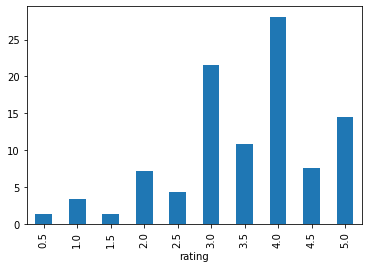

In [87]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [88]:
#reading the movies dataset
movie_list = pd.read_csv('Dataset/movies.csv')

In [89]:
len(movie_list)

27278

In [90]:
# insepcting the movie list dataframe
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [91]:
# reading the tags datast
tags = pd.read_csv('Dataset/tags.csv')

In [92]:
# inspecting the tags data frame
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [93]:
# inspecting various genres
genres = movie_list['genres']

In [94]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [95]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['IMAX',
 'Film-Noir',
 'War',
 'Mystery',
 'Adventure',
 'Horror',
 'Western',
 'Thriller',
 'Crime',
 'Musical',
 'Fantasy',
 'Animation',
 'Children',
 'Romance',
 'Action',
 'Comedy',
 '(no genres listed)',
 'Sci-Fi',
 'Documentary',
 'Drama']

In [96]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [97]:
movies_with_genres.head()

,movieId,title,genres,IMAX,Film-Noir,War,Mystery,Adventure,Horror,Western,...,Fantasy,Animation,Children,Romance,Action,Comedy,(no genres listed),Sci-Fi,Documentary,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [98]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.99


In [99]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

14026

In [100]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
#avg_movie_rating['movieId']= avg_movie_rating.index

In [101]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count
movieId,,
1,3.959323,2569
2,3.268398,1155
3,3.186861,685
4,3.000000,138
5,3.143836,657


In [102]:
len(avg_movie_rating)

14026

In [103]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [104]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count
movieId,,
1,3.959323,2569
2,3.268398,1155
3,3.186861,685
4,3.000000,138
5,3.143836,657


In [105]:
len(movie_score)

4173

In [106]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [107]:
#Calculating the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

<ipython-input-107-f069e78bacf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,mean,count,weighted_score
movieId,,,
1,3.959323,2569,3.954359
2,3.268398,1155,3.275003
3,3.186861,685,3.201228
4,3.000000,138,3.094513
5,3.143836,657,3.160667


In [108]:
#join movie details to movie ratings
movies_with_genres.index.name = None
movies_with_genres = movies_with_genres.rename_axis(None) 
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,IMAX,Film-Noir,War,Mystery,...,Fantasy,Animation,Children,Romance,Action,Comedy,(no genres listed),Sci-Fi,Documentary,Drama
0,1,3.959323,2569,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,...,1,1,1,0,0,1,0,0,0,0
1,2,3.268398,1155,3.275003,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,3,3.186861,685,3.201228,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,3.000000,138,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,5,3.143836,657,3.160667,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [109]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299,Crime|Drama
565,"Godfather, The (1972)",2137,4.388161,4.376270,Crime|Drama
46,"Usual Suspects, The (1995)",2490,4.370482,4.360468,Crime|Mystery|Thriller
403,Schindler's List (1993),2598,4.295612,4.286864,Drama|War
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037,Crime|Drama
3230,Band of Brothers (2001),228,4.353070,4.257280,Action|Drama|War
593,Casablanca (1942),1282,4.268721,4.251813,Drama|Romance
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151,Action|Adventure|Crime|Drama|Thriller
589,North by Northwest (1959),817,4.250306,4.224768,Action|Adventure|Mystery|Romance|Thriller
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788,Action|Crime|Drama|IMAX


### Reading movie_score.csv directly
<a id = "best_genre"></a>

In [110]:
#movie_score.to_csv('movie_score.csv', index = False)

movie_score = pd.read_csv('movie_score.csv')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres,IMAX,Children,Action,Fantasy,...,Animation,Horror,Adventure,Romance,Crime,Mystery,War,Musical,Drama,Western
0,1,3.959323,2569,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0
1,2,3.268398,1155,3.275003,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,3,3.186861,685,3.201228,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,3.000000,138,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,5,3.143836,657,3.160667,Father of the Bride Part II (1995),Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [112]:
#run function to return top recommended movies by genre
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
824,Duck Soup (1933),280,4.217857,4.151220
580,Singin' in the Rain (1952),542,4.097786,4.067969
3909,Dr. Horrible's Sing-Along Blog (2008),185,4.148649,4.062224
1777,Stop Making Sense (1984),119,4.142857,4.019316
2647,Fiddler on the Roof (1971),165,4.048485,3.968606
600,"Wizard of Oz, The (1939)",1229,3.947518,3.937552
588,"Gay Divorcee, The (1934)",57,4.149123,3.935381
1438,Nashville (1975),128,4.015625,3.923279
624,Top Hat (1935),120,4.004167,3.909188
3297,"Day at the Races, A (1937)",51,4.117647,3.899730


In [113]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
3230,Band of Brothers (2001),228,4.353070,4.257280
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
589,North by Northwest (1959),817,4.250306,4.224768
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
1838,Fight Club (1999),2085,4.219185,4.209399
769,Raiders of the Lost Ark (Indiana Jones and the...,2289,4.206204,4.197446
1256,Seven Samurai (Shichinin no samurai) (1954),594,4.223906,4.190510
199,Star Wars: Episode IV - A New Hope (1977),2874,4.189457,4.182637
1629,"Matrix, The (1999)",2705,4.176340,4.169242
768,"Princess Bride, The (1987)",1725,4.177391,4.166312


In [114]:
#run function to return top recommended movies by genre
best_movies_by_genre('Children',10)  

,title,count,mean,weighted_score
518,Wallace & Gromit: A Close Shave (1995),622,4.176045,4.146286
741,Wallace & Gromit: The Wrong Trousers (1993),798,4.133459,4.111568
793,"Grand Day Out with Wallace and Gromit, A (1989)",379,4.100264,4.058382
3833,WALL·E (2008),654,4.074159,4.050260
2927,My Neighbor Totoro (Tonari no Totoro) (1988),262,4.104962,4.045816
1753,"Christmas Story, A (1983)",686,4.035714,4.014495
3991,How to Train Your Dragon (2010),234,4.064103,4.003326
3931,Up (2009),502,4.030876,4.002591
4004,Toy Story 3 (2010),306,4.042484,3.996661
2989,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,183,4.046448,3.973606


In [115]:
#run function to return top recommended movies by genre
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299
565,"Godfather, The (1972)",2137,4.388161,4.376270
403,Schindler's List (1993),2598,4.295612,4.286864
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037
3230,Band of Brothers (2001),228,4.353070,4.257280
593,Casablanca (1942),1282,4.268721,4.251813
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
765,One Flew Over the Cuckoo's Nest (1975),1538,4.235696,4.222180
1838,Fight Club (1999),2085,4.219185,4.209399


In [116]:
# Creating a data frame that has user ratings accross all movies in form of matrix used in matrix factorisation
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max)

In [117]:
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    3.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN    4.0   
5          NaN    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 129350 129354 129428 129707 130052 130073 130219 130462 130490   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 130642  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 14026 columns]

In [118]:
# Apply low rank matrix factorization to find the latent features
# U, M = matrix_factorization_utilities.low_rank_matrix_factorization(ratings_df.to_numpy(),
# num_features=5,
#                                                                     regularization_amount=1.0)

In [119]:
ratings_df

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    3.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN    4.0   
5          NaN    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
7116       4.0    NaN    NaN    NaN    3.5    NaN    NaN    NaN    NaN    NaN   
7117       4.0    NaN    4.0    NaN    NaN    5.0    3.0    NaN    1.0    3.0   
7118       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7119       5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7120       4.5    4.0    NaN    NaN    NaN    NaN    4.0    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 129350 129354 129428 129707 130052 130073 130219 130462 130490   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
7116     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7117     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7118     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7119     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7120     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 130642  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
...        ...  
7116       NaN  
7117       NaN  
7118       NaN  
7119       NaN  
7120       NaN  

[7120 rows x 14026 columns]

In [120]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [121]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [122]:
ratings_movies

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
...,...,...,...,...,...
1048570,7066,88572,1.5,Fred: The Movie (2010),Comedy
1048571,7066,112412,4.5,Perfect Sisters (2014),Drama|Mystery
1048572,7077,32013,3.5,Loop the Loop (Up and Down) (Horem pádem) (2004),Comedy
1048573,7086,102596,4.5,180° South (180 Degrees South) (180° South: Co...,Documentary|Drama


### Gets the other top 10 movies which are watched by the people who saw this particular movie
<a id = "top_ten"></a>

In [123]:
#ratings_movies.to_csv('ratings_movies.csv', index = False)

ratings_movies = pd.read_csv('ratings_movies.csv')
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [124]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[1:11]

In [125]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

,userId,perc_who_watched
title,,
"Matrix, The (1999)",54,88.5
Inception (2010),53,86.9
Fight Club (1999),52,85.2
"Shawshank Redemption, The (1994)",52,85.2
"Dark Knight, The (2008)",52,85.2
"Lord of the Rings: The Fellowship of the Ring, The (2001)",51,83.6
"Lord of the Rings: The Return of the King, The (2003)",50,82.0
Pulp Fiction (1994),48,78.7
"Silence of the Lambs, The (1991)",47,77.0


In [126]:
from sklearn.neighbors import NearestNeighbors


In [127]:
avg_movie_rating.head()

,mean,count
movieId,,
1,3.959323,2569
2,3.268398,1155
3,3.186861,685
4,3.000000,138
5,3.143836,657


In [128]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

6870


In [129]:
movie_plus_10_ratings

,mean,count
movieId,,
1,3.959323,2569
2,3.268398,1155
3,3.186861,685
4,3.000000,138
5,3.143836,657
...,...,...
116797,3.950000,40
116823,3.600000,25
117176,3.576923,13


In [130]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings, on="movieId")
len(filtered_ratings)

1025973

In [131]:
filtered_ratings.head()

,movieId,mean,count,userId,rating
0,1,3.959323,2569,3,4.0
1,1,3.959323,2569,6,5.0
2,1,3.959323,2569,8,4.0
3,1,3.959323,2569,10,4.0
4,1,3.959323,2569,11,4.5


In [132]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,4.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0


In [133]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', metric='cosine')

In [134]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(movie_name) :
    #get the list of user ratings for a specific userId
    query_index = movie_list.loc[movie_list['title']==movie_name]['movieId'].dropna().values[0]
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a loop that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [135]:
print_similar_movies('Godfather, The (1972)')

Recommendations for 843    Godfather, The (1972)
Name: title, dtype: object:

1: 1195    Godfather: Part II, The (1974)
Name: title, dtype: object, with distance of 0.23770491131534777:
2: 1187    Goodfellas (1990)
Name: title, dtype: object, with distance of 0.4077577043082983:
3: 1173    Raiders of the Lost Ark (Indiana Jones and the...
Name: title, dtype: object, with distance of 0.41957422766432895:
4: 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.4220206766704162:
5: 1171    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object, with distance of 0.4373053916055094:
6: 1169    One Flew Over the Cuckoo's Nest (1975)
Name: title, dtype: object, with distance of 0.44116502131188295:
7: 602    Fargo (1996)
Name: title, dtype: object, with distance of 0.462544964302234:
8: 1182    Apocalypse Now (1979)
Name: title, dtype: object, with distance of 0.4630624594884504:
9: 1212    Terminator, The (1984)
Name: title, dt

In [136]:
print_similar_movies('Toy Story (1995)')

Recommendations for 0    Toy Story (1995)
Name: title, dtype: object:

1: 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.4203702182940916:
2: 767    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.4264775268701718:
3: 1184    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.44730365269962324:
4: 352    Forrest Gump (1994)
Name: title, dtype: object, with distance of 0.45689872537724374:
5: 640    Mission: Impossible (1996)
Name: title, dtype: object, with distance of 0.457736564895886:
6: 3027    Toy Story 2 (1999)
Name: title, dtype: object, with distance of 0.4603017587650964:
7: 1242    Back to the Future (1985)
Name: title, dtype: object, with distance of 0.46115899489577405:
8: 582    Aladdin (1992)
Name: title, dtype: object, with distance of 0.46720198545017855:
9: 476    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.468007284

In [137]:
print_similar_movies('Skyfall (2012)')

Recommendations for 19338    Skyfall (2012)
Name: title, dtype: object:

1: 18312    Dark Knight Rises, The (2012)
Name: title, dtype: object, with distance of 0.38339118524349736:
2: 19473    Looper (2012)
Name: title, dtype: object, with distance of 0.4655465783348146:
3: 20046    Hobbit: An Unexpected Journey, The (2012)
Name: title, dtype: object, with distance of 0.4791141110494047:
4: 20906    Iron Man 3 (2013)
Name: title, dtype: object, with distance of 0.4900484774282041:
5: 20994    Star Trek Into Darkness (2013)
Name: title, dtype: object, with distance of 0.4909417544965664:
6: 20124    Django Unchained (2012)
Name: title, dtype: object, with distance of 0.495007359587433:
7: 18318    Sherlock Holmes: A Game of Shadows (2011)
Name: title, dtype: object, with distance of 0.5006787501261142:
8: 18304    Hunger Games, The (2012)
Name: title, dtype: object, with distance of 0.500874607555973:
9: 18349    Mission: Impossible - Ghost Protocol (2011)
Name: title, dtype: object, wi

In [138]:
movies_with_genres.head()

,movieId,title,genres,IMAX,Film-Noir,War,Mystery,Adventure,Horror,Western,...,Fantasy,Animation,Children,Romance,Action,Comedy,(no genres listed),Sci-Fi,Documentary,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [139]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
movie_content_df = movie_content_df.to_numpy()
movie_content_df

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [140]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [141]:
# Similarity of the movies based on the content
cosine_sim

array([[5., 3., 1., ..., 1., 0., 2.],
       [3., 3., 0., ..., 1., 0., 2.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [2., 2., 0., ..., 1., 0., 3.]])

In [146]:
cosine_sim.shape

(27278, 27278)

In [147]:
# from numpy import savez_compressed

# savez_compressed('cosine.npz', cosine_sim)
#savetxt('cosine.csv', cosine_sim, delimiter=',')

In [150]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Kein Bund für's Leben (2007)          27273
Feuer, Eis & Dosenbier (2002)         27274
The Pirates (2014)                    27275
Rentun Ruusu (2001)                   27276
Innocence (2014)                      27277
Length: 27278, dtype: int64

In [151]:
indcs = indicies.to_dict()
rev_ind = {}
for key,val in indcs.items():
    rev_ind[val] = key
rev_ind[19338]

'Skyfall (2012)'

In [153]:
# import pickle

# a_file = open("indicies.pkl", "wb")
# pickle.dump(indcs, a_file)
# a_file.close()

In [152]:
indcs['Skyfall (2012)']

19338

In [155]:
# movie_content_df_temp.head()

,movieId,title,genres,IMAX,Film-Noir,War,Mystery,Adventure,Horror,Western,...,Fantasy,Animation,Children,Romance,Action,Comedy,(no genres listed),Sci-Fi,Documentary,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [156]:
# movie_content_df_temp.to_csv('mv_cnt_tmp.csv', index = False)

### Directly getting top 10 movies based on content similarity

In [158]:
movie_content_df_temp = pd.read_csv('mv_cnt_tmp.csv')

movie_content_df_temp.head()

,movieId,title,genres,IMAX,Film-Noir,War,Mystery,Adventure,Horror,Western,...,Fantasy,Animation,Children,Romance,Action,Comedy,(no genres listed),Sci-Fi,Documentary,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [154]:
a_file = open("indicies.pkl", "rb")
inds = pickle.load(a_file)
a_file.close()
inds['Skyfall (2012)']

19338

In [148]:
from numpy import load

data_dict = load('cosine.npz')
cosine_sim = data_dict['arr_0']
cosine_sim

array([[5., 3., 1., ..., 1., 0., 2.],
       [3., 3., 0., ..., 1., 0., 2.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [2., 2., 0., ..., 1., 0., 3.]])

In [149]:
cosine_sim.shape

(27278, 27278)

In [162]:
#Gets the top 10 similar movies based on the content
def get_similar_movies_based_on_content(movie_name) :
    movie_index = inds[movie_name]
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    if(movie_index in movie_indices):
        movie_indices.remove(movie_index)
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies[:10]

In [ ]:
#indicies["Skyfall (2012)"]

In [163]:
get_similar_movies_based_on_content('Skyfall (2012)')

[(6260, 4.0), (6822, 4.0), (11018, 4.0), (11826, 4.0), (15203, 4.0), (16733, 4.0), (18315, 4.0), (18349, 4.0), (19338, 4.0), (20615, 4.0), (9, 3.0)]
[6260, 6822, 11018, 11826, 15203, 16733, 18315, 18349, 20615, 9]


,title,genres
6260,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6822,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
11018,Poseidon (2006),Action|Adventure|Thriller|IMAX
11826,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
15203,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
16733,Sanctum (2011),Action|Adventure|Drama|Thriller|IMAX
18315,"Bourne Legacy, The (2012)",Action|Adventure|Drama|Thriller|IMAX
18349,Mission: Impossible - Ghost Protocol (2011),Action|Adventure|Thriller|IMAX
20615,G.I. Joe: Retaliation (2013),Action|Adventure|Sci-Fi|Thriller|IMAX
9,GoldenEye (1995),Action|Adventure|Thriller


In [164]:
get_similar_movies_based_on_content('Jumanji (1995)')

[(0, 3.0), (1, 3.0), (55, 3.0), (59, 3.0), (124, 3.0), (255, 3.0), (542, 3.0), (553, 3.0), (624, 3.0), (653, 3.0), (664, 3.0)]
[0, 55, 59, 124, 255, 542, 553, 624, 653, 664]


,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
55,Kids of the Round Table (1995),Adventure|Children|Fantasy
59,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
124,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy
255,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance
542,Super Mario Bros. (1993),Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
553,"Pagemaster, The (1994)",Action|Adventure|Animation|Children|Fantasy
624,All Dogs Go to Heaven 2 (1996),Adventure|Animation|Children|Fantasy|Musical|R...
653,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
664,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...


In [165]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()

,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [166]:
#get ordered list of userIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [167]:
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [168]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,2,3.5,1,0
1,1,29,3.5,28,0
2,1,32,3.5,31,0
3,1,47,3.5,46,0
4,1,50,3.5,49,0


In [169]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

838860
209715


In [170]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
946744,5832,3618,3.0,3408,5831
795490,531,2338,1.5,2192,530
218888,3797,3224,2.0,3048,3796
580437,3411,68791,3.5,10999,3410
687690,6575,1089,4.5,1044,6574


In [171]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
67612,1244,8957,4.0,7750,1243
573655,3132,3527,4.0,3322,3131
6877,156,2456,2.0,2309,155
903539,5358,590,5.0,578,5357
286359,4855,73023,3.5,11388,4854


In [172]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

7120
14026


#### User_index is row and Movie_index is column and value is rating

In [176]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(7120, 14026)

In [177]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(7120, 14026)

In [178]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
df_train['rating'].max()

5.0

In [180]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [181]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
from scipy.sparse.linalg import svds

rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 3.3815340046294016
Matrix Factorisation with 2 latent features has a RMSE of 2.8318466180645654
Matrix Factorisation with 5 latent features has a RMSE of 2.270509008845397
Matrix Factorisation with 20 latent features has a RMSE of 0.12056335049977118
Matrix Factorisation with 40 latent features has a RMSE of 0.2529999325728296
Matrix Factorisation with 60 latent features has a RMSE of 0.4145888651453946
Matrix Factorisation with 100 latent features has a RMSE of 0.25500306534137174
Matrix Factorisation with 200 latent features has a RMSE of 0.41988162205674007


In [182]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,-0.036751,1.573445,-0.400991,-0.050674,0.130500,-0.115503,-0.008551,-0.087276,-0.106030,-0.293177,...,0.008498,-0.011356,-0.014930,-0.000191,-0.005742,0.0,-0.046324,-0.016602,0.027122,-0.017225
1,0.194869,0.584277,0.016326,0.065379,-0.236161,0.290256,-0.039821,-0.057155,-0.056304,-0.253019,...,0.009850,0.009207,0.005006,0.001274,-0.001858,0.0,-0.012725,-0.009898,-0.000687,-0.005573
2,-0.145490,0.103897,-0.184319,-0.163551,-0.236428,-0.186115,0.377279,0.020358,-0.110922,-0.160579,...,-0.009257,-0.006534,0.021774,-0.000340,-0.003839,0.0,0.027449,0.006551,0.007305,-0.011516
3,-0.340171,0.767674,0.460418,0.016307,0.509177,2.292108,0.081366,0.162166,0.052344,1.026162,...,-0.004623,0.006106,-0.007317,0.000230,0.002195,0.0,0.004895,-0.002401,-0.002955,0.006586
4,0.749996,0.917444,0.690938,-0.117357,0.584446,0.686840,0.977891,-0.000131,0.341455,-0.017176,...,-0.014289,0.021430,-0.011738,0.000054,-0.001433,0.0,0.003520,-0.001542,0.015437,-0.004300


In [183]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [184]:
#choose a user ID
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

User ID : 1 has already rated 175 movies


,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1155,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
1603,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3915,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
6156,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
130066,1,8507,5.0,Freaks (1932),Crime|Drama|Horror
130115,1,8636,4.5,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX
130973,1,8690,3.5,Slaughterhouse-Five (1972),Comedy|Drama|Sci-Fi|War
131002,1,8961,4.0,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy


In [185]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 predictions for User 1


,ratings,movieId,title,genres
0,4.806301,5622,Charly (2002),Comedy|Drama|Romance
1,4.347485,6699,Once Upon a Time in the Midlands (2002),Drama
2,4.299020,312,Stuart Saves His Family (1995),Comedy
3,4.218829,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
4,4.161974,1088,Dirty Dancing (1987),Drama|Musical|Romance
5,4.142812,2605,Entrapment (1999),Crime|Thriller
6,4.050747,1142,Get Over It (1996),Drama
7,3.919232,254,Jefferson in Paris (1995),Drama
8,3.916309,287,Nina Takes a Lover (1994),Comedy|Romance
9,3.872588,1327,"Amityville Horror, The (1979)",Drama|Horror|Mystery|Thriller


In [186]:
#count number of unique users
numUsers = df_train.userId.unique().shape[0]
#count number of unitque movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

838860
7120
13465


In [187]:
#Separate out the values of the df_train data set into separate variables
Users = df_train['userId'].values
Movies = df_train['movieId'].values
Ratings = df_train['rating'].values
print(Users),print(len(Users))
print(Movies),print(len(Movies))
print(Ratings),print(len(Ratings))

[5832  531 3797 ... 3879 2397  238]
838860
[ 3618  2338  3224 ... 69757 51540  1196]
838860
[3.  1.5 2.  ... 3.  4.  4.5]
838860


(None, None)

In [194]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Reshape 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [195]:
from keras.utils import plot_model

In [196]:
# Couting no of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

(7120, 14026)

In [197]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [198]:
# Splitting the data into train and test.
train, test = train_test_split(ratings, test_size=0.2)

In [199]:
train.head()

,userId,movieId,rating
827628,5508,3442,4.0
1000418,6743,260,4.0
439482,2987,2586,4.0
1028646,6975,69,2.0
752207,5010,1586,4.0


In [200]:
test.head()

,userId,movieId,rating
54021,393,967,4.0
85626,608,872,4.0
780776,5194,1532,5.0
359563,2419,2698,3.0
613491,4102,337,5.0


In [201]:
n_users, n_movies = len(ratings.userId.unique()), len(ratings.movieId.unique())

In [204]:
# Returns a neural network model which performs matrix factorisation
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
    prod = keras.layers.dot([movie_vec, user_vec], axes=1)
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [205]:
model = matrix_factorisation_model_with_n_latent_factors(20)

In [206]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        280540      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        142420      User[0][0]                       
_______________________________________________________________________________________

In [208]:
#Training the model
history = model.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

Epoch 1/10
26215/26215 [==============================] - 238s 9ms/step - loss: 0.4897
Epoch 2/10
 3658/26215 [===>..........................] - ETA: 3:25 - loss: 0.4492

KeyboardInterrupt: 

In [391]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [392]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.64568581169682659

In [393]:
#Getting summary of movie embeddings
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,14027.000000,14027.000000,14027.000000,14027.000000,14027.000000
mean,-0.584796,0.554704,0.573179,0.543056,-0.572827
std,0.325645,0.370988,0.344475,0.362717,0.511071
min,-1.963836,-1.217293,-1.716879,-1.473400,-3.367397
25%,-0.780295,0.344472,0.371849,0.323731,-0.818733
50%,-0.612994,0.601410,0.603311,0.580123,-0.592860
75%,-0.393885,0.770797,0.771625,0.758554,-0.268880
max,1.737474,2.446507,2.321894,2.295453,2.053888


In [394]:
# Getting summary of user embeddings from the model
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,7121.000000,7121.000000,7121.000000,7121.000000,7121.000000
mean,-1.441774,1.158949,0.995655,1.158363,-0.922638
std,0.445552,0.593889,0.586042,0.671087,0.661188
min,-2.832839,-2.562927,-2.131705,-2.797889,-3.622658
25%,-1.729032,0.822518,0.661902,0.759129,-1.350732
50%,-1.473317,1.157800,1.014819,1.188419,-0.917977
75%,-1.186000,1.514922,1.348338,1.562538,-0.503780
max,1.541291,3.823552,3.735326,4.918538,1.842927


In [395]:
from keras.constraints import non_neg

In [396]:
# Returns a neural network model which performs matrix factorisation with additional constraint on embeddings(that they can't be negative)
def matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Non-Negative-Movie-Embedding',embeddings_constraint=non_neg())(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding',embeddings_constraint=non_neg())(user_input))
    prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [397]:
model2 = matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(5)

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [412]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Non-Negative-Movie-Embedding (E (None, 1, 5)         70135       Item[0][0]                       
__________________________________________________________________________________________________
Non-Negative-User-Embedding (Em (None, 1, 5)         35605       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [398]:
history_nonneg = model2.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)

In [399]:
movie_embedding_learnt = model2.get_layer(name='Non-Negative-Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,14027.000000,14027.000000,14027.000000,14027.000000,14027.000000
mean,0.593803,0.577534,0.539951,0.556110,0.574022
std,0.324521,0.325505,0.290940,0.302161,0.321179
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.386639,0.344631,0.341899,0.355270,0.354777
50%,0.605978,0.608381,0.571152,0.579772,0.605287
75%,0.778993,0.786552,0.728412,0.746384,0.777170
max,2.186076,1.769787,1.848414,1.963175,2.172031


In [401]:
y_hat = np.round(model2.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [402]:
mean_absolute_error(y_true, y_hat)

0.64118446463057011

In [409]:
# Returns a neural network model which does recommendation
def neural_network_model(n_latent_factors_user, n_latent_factors_movie):
    
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)


    concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

In [410]:
model3 = neural_network_model(10,13)

C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\gureddy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [411]:
history_neural_network = model3.fit([train.userId, train.movieId], train.rating, epochs=50, verbose=0)

In [413]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 13)        182351      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        71210       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [417]:
y_hat = np.round(model3.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [418]:
mean_absolute_error(y_true, y_hat)

0.6582647879264717